In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import bq_helper
from bq_helper import BigQueryHelper
# https://www.kaggle.com/sohier/introduction-to-the-bq-helper-package
google_analytics = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="data:google_analytics_sample")

In [ ]:
bq_assistant = BigQueryHelper("bigquery-public-data", "google_analytics_sample")

# **Main Query**

In [ ]:
#MAIN QUERY
main_query = """SELECT 
                   session_id,
                   session_bounce_count
                   channel_grouping,
                   page_url,
                   hit_type,
                   event_action,
                   event_value,
                   hit_start_time,
                   interaction_hit_flag,
                   entrance_flag,
                   exit_flag,
                   product_name,
                   transaction_id,
                   transaction_sales_amount,
                   transaction_currency_code,
                   product_array.productSKU as product_sku,
                   product_array.v2ProductName as product_name,
                   product_array.productQuantity as product_quantity,
                   ROUND(product_array.productPrice/1000000,2) as product_price,
                   ROUND(product_array.productRevenue/1000000,2) as product_revenue
            FROM
            (SELECT date, 
                   fullVisitorId as session_id,
                   channelGrouping as channel_grouping,
                   totals.bounces as session_bounce_count,
                   hits.page.pagePath as page_url,
                   hits.type as hit_type,
                   hits.eventInfo.eventAction as event_action,
                   hits.eventInfo.eventValue as event_value,
                   hits.time as hit_start_time,
                   hits.isInteraction as interaction_hit_flag,
                   hits.isEntrance as entrance_flag,
                   hits.isExit as exit_flag,
                   hits.item.productName as product_name,
                   hits.transaction.transactionID as transaction_id,
                   hits.product as product_array,
                   ROUND(hits.transaction.transactionRevenue/1000000,2) as transaction_sales_amount,
                   hits.transaction.currencyCode as transaction_currency_code
            FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20160801` as GA,
            UNNEST(GA.hits) as hits
            ORDER BY session_id, hit_start_time ASC) as t CROSS JOIN UNNEST(t.product_array) as product_array;"""

main_query = google_analytics.query_to_pandas_safe(main_query)

main_query.head(5)

# Metric Calculations

**Conversion Rate**

In [ ]:
#Conversion Rate
df = main_query.groupby('session_id')['product_revenue'].sum().reset_index().sort_values(by = 'product_revenue', ascending = False)

total_sessions = len(df)
sessions_w_transactions = len(df.query('product_revenue!=0'))
conversion_pct = round((sessions_w_transactions / total_sessions) * 100,2)

print("Comversion Rate: " + str(conversion_pct) + " %")

**Bounce Rate**

In [ ]:
#Bounce Rate - should be calculated at the page level
#for simplicity let's calculate bounce rate of /home
query = """ SELECT
                CONCAT(fullVisitorId,visitId) as session_id,
                sum(totals.bounces) as total_bounces_this_session
            FROM
                `bigquery-public-data.google_analytics_sample.ga_sessions_20160801` AS GA
            GROUP BY session_id
            ORDER BY total_bounces_this_session DESC"""

total_sessions = google_analytics.query_to_pandas_safe(query)


sessions_with_bounces = total_sessions[total_sessions['total_bounces_this_session']>0]
bounce_rate = round((len(sessions_with_bounces) / len(total_sessions))*100,2)

print("Bounce Rate: " + str(bounce_rate) + "%")

# Testing

In [ ]:
#Generate the list of dates from 2016-08-01 to 2017-08-01

from datetime import datetime, timedelta

# Start and end dates
start_date_str = "2016-08-01"
end_date_str = "2017-08-01"

# Convert string dates to datetime objects
start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
end_date = datetime.strptime(end_date_str, "%Y-%m-%d")

# Initialize an empty list to store dates
date_list = []

# Populate the list with dates
current_date = start_date
while current_date <= end_date:
    date_list.append(current_date.strftime("%Y%m%d"))
    current_date += timedelta(days=1)
    

In [ ]:
full_date_list = []
total_sessions_list = []
sessions_with_bounces_list = []

for i in date_list:  
    table_name = 'bigquery-public-data.google_analytics_sample.ga_sessions_' + str(i)
    query = f""" SELECT
                    CONCAT(fullVisitorId,visitId) as session_id,
                    sum(totals.bounces) as total_bounces_this_session
                FROM
                    `{table_name}` AS GA
                GROUP BY session_id
                ORDER BY total_bounces_this_session DESC"""

    total_sessions = google_analytics.query_to_pandas_safe(query)


    sessions_with_bounces = total_sessions[total_sessions['total_bounces_this_session']>0]
    bounce_rate = round((len(sessions_with_bounces) / len(total_sessions))*100,2)
    
    #add values to the list
    full_date_list.append(datetime.strptime(i, "%Y%m%d"))
    total_sessions_list.append(len(total_sessions))
    sessions_with_bounces_list.append(len(sessions_with_bounces))

df = pd.DataFrame()
df['full_date'] = full_date_list
df['total_sessions'] = total_sessions_list
df['sessions_with_bounces'] = sessions_with_bounces_list

df

In [ ]:
df.to_csv('sessions_and_bounces_by_day.csv')

In [130]:
import pandas as pd

df['month'] = df['full_date'].dt.month
df['year'] = df['full_date'].dt.year

df1 = df.groupby(['month', 'year'])[['total_sessions', 'sessions_with_bounces']].sum().reset_index()
df1 = df1.sort_values(by = ['year','month'], ascending = True)
df1['bounce_rate_pct'] = round((df1['sessions_with_bounces'] / df1 ['total_sessions']) * 100,2)

df1

,month,year,total_sessions,sessions_with_bounces,bounce_rate_pct
7,8,2016,74759,36585,48.94
9,9,2016,71032,34808,49.00
10,10,2016,97506,52613,53.96
11,11,2016,113972,57519,50.47
12,12,2016,79124,35495,44.86
0,1,2017,64694,31326,48.42
1,2,2017,62192,31279,50.29
2,3,2017,69931,35916,51.36
3,4,2017,67126,34535,51.45
4,5,2017,65371,31205,47.74


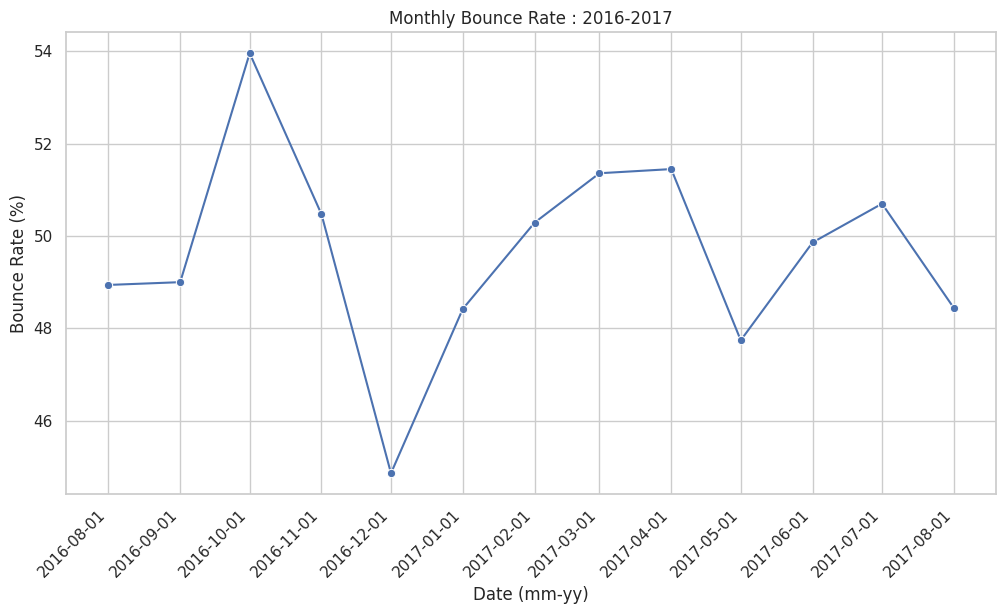

In [141]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df1['date'] = pd.to_datetime(df1[['year', 'month']].assign(day=1))

# Sort the DataFrame by the datetime column
df1 = df1.sort_values('date')

# Create a time series plot using Seaborn
sns.set(style="whitegrid")  # Optional: Set the seaborn style
plt.figure(figsize=(12, 6))  # Optional: Set the figure size

# Plot the time series
sns.lineplot(x='date', y='bounce_rate_pct', data=df1, marker='o')

# Format the x-axis labels as 'mm-yy'

plt.xticks(rotation=45, ha='right', ticks=df1['date'])
plt.xlabel('Date (mm-yy)')
plt.ylabel('Bounce Rate (%)')
plt.title('Monthly Bounce Rate : 2016-2017')

# Show the plot
plt.show()
